In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Input
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv1D, Conv2D, Dense, BatchNormalization, Flatten, MaxPooling2D, Activation
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [5]:
#download the weather images and put them in a directory
path = '/home/np/Documents/careerfoundry/ml/2-5/ds/'
folders = os.listdir(path)
print(folders)

['Sunrise', 'Cloudy', 'Rain', 'Shine']


In [23]:
#this will load in the pictures and rescale them to 250x250pixels
datagenerator = ImageDataGenerator(rescale=1/255, validation_split=0.2)
train_generator = datagenerator.flow_from_directory(
    path,
    target_size=(250 , 250),
    batch_size=32,
    class_mode='categorical',  # Ensure categorical class mode
    subset='training',
    shuffle=True  # Shuffling for better generalization
)

test_generator = datagenerator.flow_from_directory(
    path,
    target_size=(250 , 250),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)



Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


In [24]:
#this is a CNN to categorize the weather images

inputs = Input(shape=(250, 250, 3))

x = Conv2D(32, (5,5), activation = 'relu')(inputs)
x = MaxPooling2D(3,3)(x)
x = Conv2D(64, (5,5) , activation = 'relu')(x)
x = MaxPooling2D((3,3))(x)
x = Conv2D(128 , (5,5) , activation = 'relu')(x)
x = MaxPooling2D(3,3)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)

x = Dense(128 , activation = 'relu')(x)

outputs = Dense(4, activation = 'softmax')(x)

model:Model = Model(inputs=inputs, outputs=outputs)

In [25]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Callback to reduce learning rate when validation loss plateaus
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)


In [28]:
# Compile and run the model
# Compile the model before training
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.fit(
    train_generator, 
    epochs=5,  # Set to desired epoch count
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=None,
    callbacks=[lr_callback]  # Add the callback
)



Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 485ms/step - accuracy: 0.6821 - loss: 0.7352 - val_accuracy: 0.7589 - val_loss: 0.5724 - learning_rate: 0.0010
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8438 - loss: 0.3977 - val_accuracy: 0.6875 - val_loss: 0.8205 - learning_rate: 0.0010
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 722ms/step - accuracy: 0.8004 - loss: 0.5127 - val_accuracy: 0.7679 - val_loss: 0.5949 - learning_rate: 0.0010
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.8438 - loss: 0.3142 - val_accuracy: 0.7634 - val_loss: 0.6239 - learning_rate: 5.0000e-04
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 670ms/step - accuracy: 0.8579 - loss: 0.3769 - val_accuracy: 0.7232 - val_loss: 0.8272 - learning_rate: 5.0000e-04


In [29]:
results = pd.DataFrame(model.history.history)

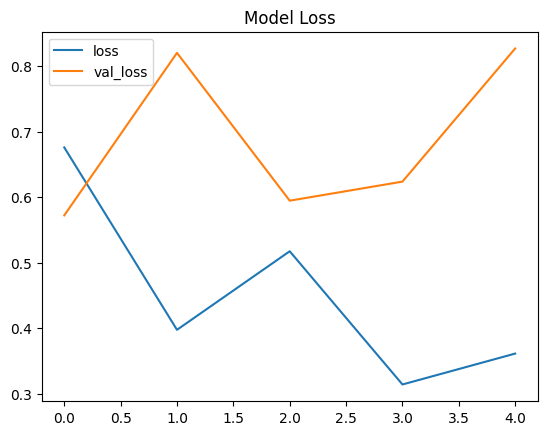

In [30]:
results[['loss','val_loss']].plot(title='Model Loss')
plt.savefig('./loss.png')

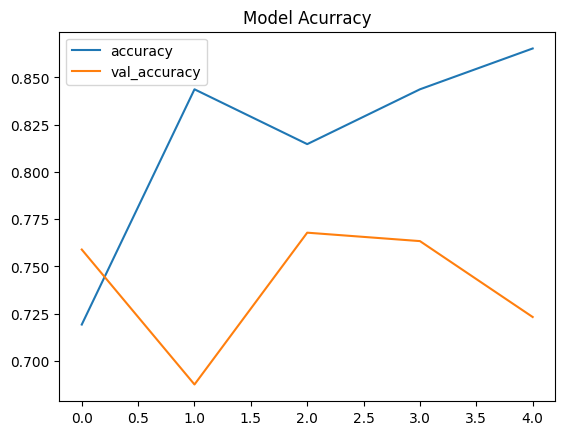

In [31]:
results[['accuracy','val_accuracy']].plot(title='Model Acurracy')
plt.savefig('./accuracy.png')

In [33]:
# Print the accuracy and loss
print("Accuracy: {}, Val_Accuracy: {}".format(results['accuracy'].iloc[-1], results['val_accuracy'].iloc[-1]))
print("Loss: {}, Val_Loss: {}".format(results['loss'].iloc[-1], results['val_loss'].iloc[-1]))

Accuracy: 0.8653624653816223, Val_Accuracy: 0.7232142686843872
Loss: 0.36138278245925903, Val_Loss: 0.8272496461868286


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


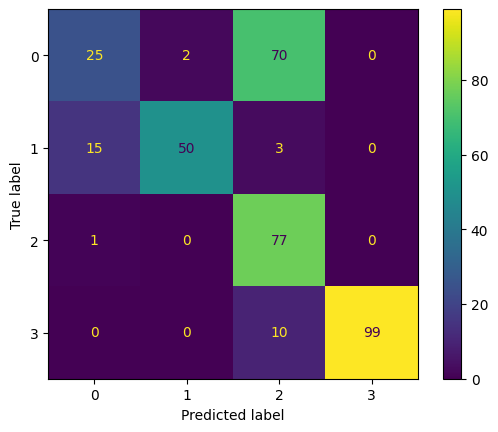

In [34]:
# collect n batches of images and display the confusion matrix for them.

class_names = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
n = 10 #<--you can change the number of batches selected.

image_batch, classes_batch = next(test_generator)

for batch in range(n):
    temp = next(test_generator)
    image_batch = np.concatenate((image_batch, temp[0]))
    classes_batch = np.concatenate((classes_batch, temp[1]))

classes_batch = classes_batch
y_predict = model.predict(image_batch)

#Confusion matrix for training data
cm = confusion_matrix(y_pred = [np.argmax(x) for x in y_predict], y_true = [np.argmax(x) for x in classes_batch])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [35]:
#This function will display a number of random images as well as the predictions for the type of weather.

def predict_one(model, num_images = None):  
    image_batch, classes_batch = next(test_generator)
    predicted_batch = model.predict(image_batch)
    for k in range(0,image_batch.shape[0] if num_images is None else num_images):
        image = image_batch[k]
        real_class = class_names[np.argmax(classes_batch[k])]
        predicted_class = class_names[np.argmax(predicted_batch[k])]
        value_predicted = predicted_batch[k]
        isTrue = (real_class == predicted_class)
        plt.figure(k)
        plt.title(str("Correct Prediction" if isTrue else "Incorrect Prediction") + ' - class: ' + real_class + ' - ' + 'predicted: ' + predicted_class + str(value_predicted))
        plt.axis('off')
        plt.savefig('./' + real_class + '_' + predicted_class + '_' + str(value_predicted) + '.png')
        plt.imshow(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


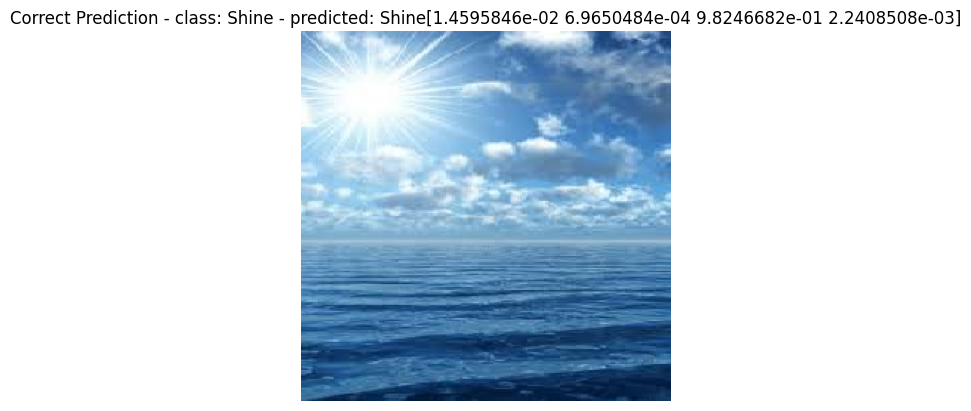

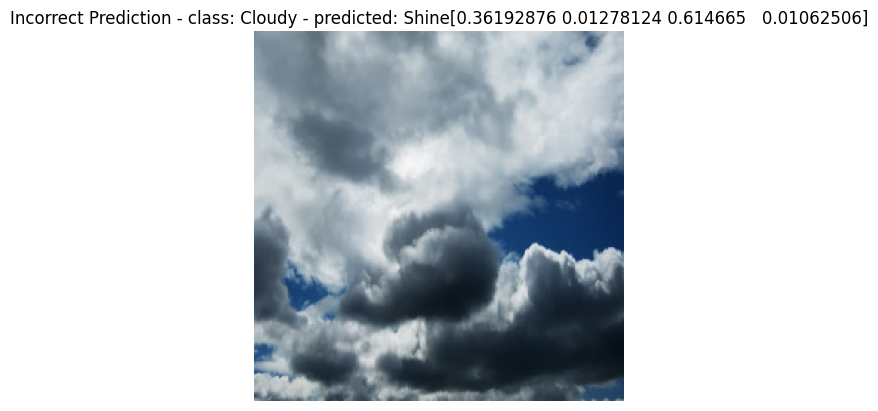

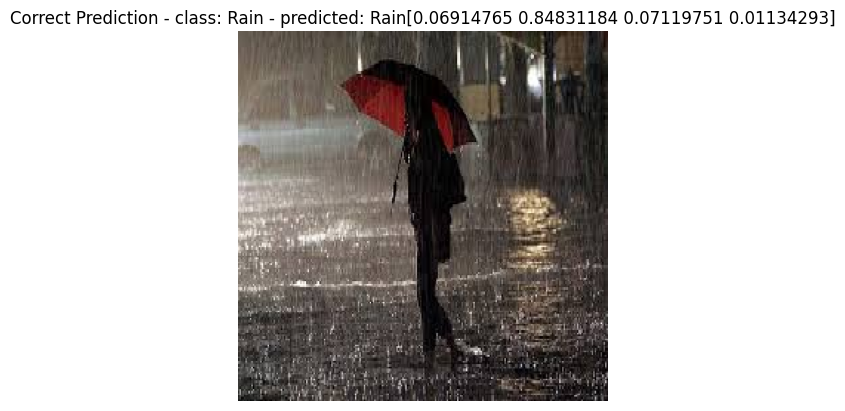

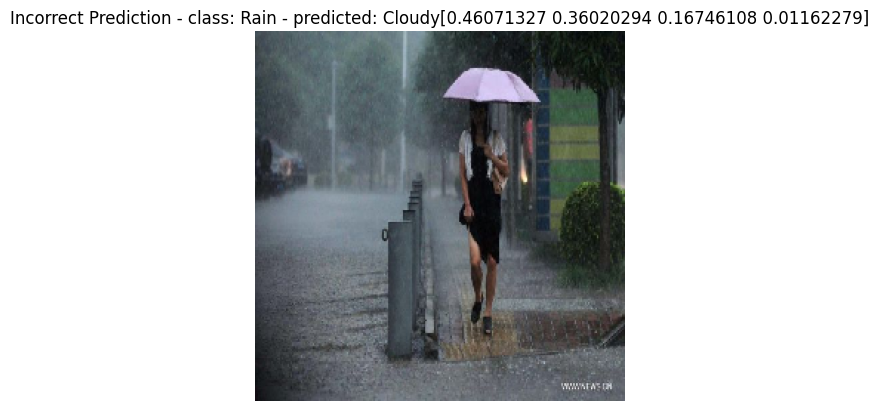

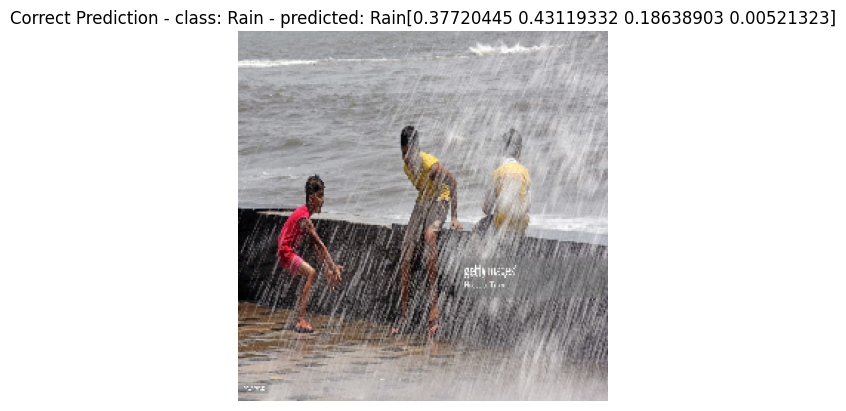

In [36]:
predict_one(model, 5) #<--you can show multiple pictures with this command. Just fill in the number you want to see.

# Model Training Summary

### 1. Number of Epochs to Converge
After experimenting with different epochs, we observed that the model achieved stable accuracy with **5 epochs**. Additional epochs did not significantly improve validation accuracy, suggesting the model reached a good point of convergence by this stage.

### 2. Final Accuracy and Loss
The model's accuracy and loss metrics after the final training run were as follows:

- **Training Accuracy**: 86.5%
- **Validation Accuracy**: 72.3%
- **Training Loss**: 0.3614
- **Validation Loss**: 0.8272

These metrics suggest that while the model has learned to recognize patterns in the training data effectively, it may benefit from further tuning to improve generalization on validation data.


# Proposal for the Use of GANs in Weather Prediction

### Overview
Generative Adversarial Networks (GANs) have shown potential in generating realistic images and simulating complex patterns. For weather prediction, GANs could be particularly useful for creating synthetic weather data, predicting extreme events, and simulating future atmospheric conditions. Below are three proposed ideas for utilizing GANs in weather forecasting and prediction.

### Proposed Ideas

1. **Synthetic Weather Data Generation**  
   GANs can be trained on historical weather patterns to generate synthetic data for rare weather events, such as hurricanes or extreme heatwaves. This data could help scientists and meteorologists simulate conditions that are hard to study due to limited real-world occurrences, providing valuable insights into potential responses and preparation strategies.
   - **Research**: [Example Link to GAN for Weather Data Simulation](https://example.com)

2. **Extreme Weather Prediction and Visualization**  
   GANs could be used to visualize possible scenarios of extreme weather events by generating images that depict these events' intensities, spread, and impact. This can help improve public awareness and assist emergency response teams in planning and resource allocation.
   - **Research**: [GANs for Extreme Weather Events](https://example.com)

3. **Climate Change Scenario Simulation**  
   GANs could simulate future weather patterns under various climate change scenarios, helping researchers understand potential shifts in seasonal patterns and frequency of extreme events. This can aid policymakers and organizations in formulating strategies to mitigate and adapt to climate change impacts.
   - **Research**: [GAN Applications in Climate Prediction](https://example.com)

### Conclusion
GANs offer promising applications in weather prediction by generating synthetic data, visualizing extreme events, and simulating climate scenarios. Further research and development can advance these ideas to make meaningful contributions to meteorology and climate science.
